In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm

# Data

In [2]:
from data import AVA

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Create training and validation datasets
image_datasets = {x: AVA(None, train=(x=='train'), transform=data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [3]:
# Number of classes in the dataset
num_classes = 10

# Weight Path
weight_path = 'weights/dense121_all.pt'

In [4]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Sequential(
    nn.Linear(num_ftrs,num_classes),
    nn.Softmax(1)
)    

In [5]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Train

In [6]:
num_epochs = 10

In [7]:
opt = optim.Adam(model_ft.parameters(),lr=3e-7)

In [8]:
from scipy import stats
def train_model(model, dataloaders, criterion, optimizers, num_epochs=25):
    val_loss_history = []

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0
            
            true_means = []
            pred_means = []
            
            true_stds = []
            pred_stds = []

            # Iterate over data.
            import sys; sys.stdout.flush()
            pbar = tqdm(dataloaders[phase], desc='Epoch {}/{} {}'.format(epoch, num_epochs - 1, phase))
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                weight_votes = torch.arange(10, dtype=torch.float, device=device) + 1

                # zero the parameter gradients
                opt.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Mean
                    true_mean = torch.matmul(labels, weight_votes)
                    for m in true_mean:
                        true_means.append(m.item())

                    pred_mean = torch.matmul(outputs, weight_votes)
                    for m in pred_mean:
                        pred_means.append(m.item())
                        
                    # STD
                    true_std = torch.sqrt((labels * torch.pow((weight_votes - true_mean.view(-1,1)), 2)).sum(dim=1))
                    pred_std = torch.sqrt((outputs * torch.pow((weight_votes - pred_mean.view(-1,1)), 2)).sum(dim=1))
                    
                    for s in true_std:
                        true_stds.append(s.item())
                    for s in pred_std:
                        pred_stds.append(s.item())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        opt.step()

                # statistics
                epoch_loss += loss.item() * labels.size(0)
                
                pbar.set_postfix_str('Losses: accum avg {:.4f}, batch avg {:.4f}'
                                     .format(epoch_loss / len(dataloaders[phase].dataset), loss.item()))
                
            m_lcc, _ = stats.pearsonr(true_means, pred_means)
            s_lcc, _ = stats.pearsonr(true_stds, pred_stds)
            
            m_rank, _ = stats.spearmanr(true_means, pred_means)
            s_rank, _ = stats.spearmanr(true_stds, pred_stds)
            
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.title("Mean Corr (Linear, Rank): ({:.3f}, {:.3f})".format(m_lcc, m_rank))
            plt.xlabel("True Mean")
            plt.ylabel("Predicted Mean")
            plt.scatter(true_means, pred_means, alpha=0.1)
            plt.subplot(1,2,2)
            plt.title("STD Corr (Linear, Rank) ({:.3f}, {:.3f})".format(s_lcc, s_rank))
            plt.xlabel("True STD")
            plt.ylabel("Predicted STD")
            plt.scatter(true_stds, pred_stds, alpha=0.1)
            plt.show()
            
            torch.save(model.state_dict(), weight_path)
        
    return model, val_loss_history

In [9]:
if os.path.exists(weight_path):
    model_ft.load_state_dict(torch.load(weight_path))
    print("Loaded saved weights from '{}'".format(weight_path))
else:
    print("Starting weights from scratch")

Loaded saved weights from 'weights/dense121_all.pt'


In [10]:
# Setup the loss fxn
def EMDLoss(input, target):
    batch_size = input.shape[0]
    cdf_target = torch.cumsum(target, dim=1)
    cdf_pred = torch.cumsum(input, dim=1)
    cdf_diff = cdf_pred - cdf_target
    loss = torch.sqrt(torch.mean(torch.pow(torch.abs(cdf_diff), 2)))
    return loss.mean()

Epoch 0/9 train: 100%|██████████| 3194/3194 [1:10:41<00:00,  1.07s/it, Losses: accum avg 0.0729, batch avg 0.0763]


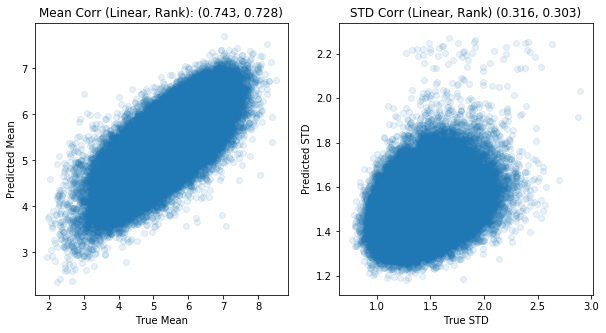

Epoch 0/9 val: 100%|██████████| 799/799 [05:55<00:00,  2.75it/s, Losses: accum avg 0.0835, batch avg 0.0900]


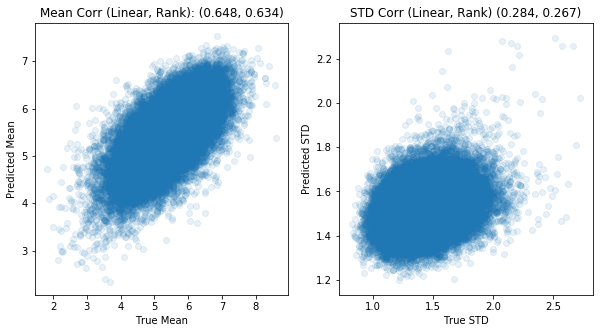

Epoch 1/9 train:   3%|▎         | 110/3194 [02:27<1:08:40,  1.34s/it, Losses: accum avg 0.0025, batch avg 0.0649]

KeyboardInterrupt: 

In [11]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, EMDLoss, opt, num_epochs=num_epochs)

# Accuracy on AVA2

In [ ]:
from data import AVA2
ava2 = AVA2(None, train=False, transform=data_transforms['val'])
ava2_loader = torch.utils.data.DataLoader(ava2, batch_size=1, num_workers=4)

In [ ]:
with torch.no_grad():
    model_ft.eval()
    num_corr = 0
    for inputs, labels in tqdm(ava2_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(inputs)
        
        weight_votes = torch.arange(10, dtype=torch.float, device=device) + 1
        pred_mean = torch.matmul(outputs, weight_votes)
        
        batch_corr = ((pred_mean > 5) == labels.byte()).sum()
        num_corr += batch_corr.item()
        import pdb; pdb.set_trace()
    
print("Accuracy {:.4f}".format(num_corr/len(ava2)))